## Restaurant Simple Recommender Systems 

In [63]:
import zipfile
import pandas as pd
import numpy as np
from collections import Counter
from operator import itemgetter
import matplotlib.pyplot as plt
import scipy.sparse as sp
import csv
import scipy.linalg as la
%config InlineBackend.figure_format = 'svg'

Find the top 10 states in terms of the number of restaurants' reviews 

In [6]:
business = pd.read_csv('./yelp-dataset/yelp-dataset/yelp_business.csv')
business_rest = business[business['categories'].str.lower().str.contains('restaurant')]
state = business_rest.state
state = Counter(state)
state_sort = sorted(state.items(),
                   reverse=True,
                   key=itemgetter(1))[:10]
state_top10, count_top10 = zip(*state_sort)


Text(0,0.5,'Number of review')

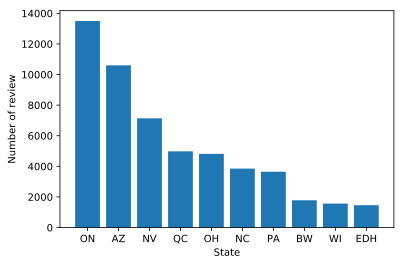

In [19]:
plt.bar(range(len(count_top10)),np.array(count_top10))
plt.xticks(range(len(count_top10)),np.array(state_top10))
plt.xlabel('State')
plt.ylabel('Number of review')

In [20]:
# extract restaurants in Pittsburgh only
business['categories'] = business['categories'].str.lower()
business_PA = business[np.array(business['state']=='PA') & np.array(business['categories'].str.contains('restaurants'))]
bid_PA = business_PA['business_id']

In [21]:
# create a dictionary for restaurant name and business id
# remove double quote and slash in restaurant's name 
name = np.array([name.replace('\"','') for name in business_PA['name']])
restaurant_id = dict(zip(business_PA['business_id'],name))

In [24]:
# some vis??
business_PA.head()

,business_id,name,neighborhood,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories
10,XOSRcvtaKc_Q5H1SAzN20A,"""East Coast Coffee""",NaN,"""737 West Pike St""",Houston,PA,15342,40.241548,-80.212815,4.5,3,0,breakfast & brunch;gluten-free;coffee & tea;fo...
44,BnuzcebyB1AfxH0kjNWqSg,"""Carrabba's Italian Grill""",NaN,"""245 Lancaster Ave""",Frazer,PA,19355,40.041003,-75.542497,3.5,25,0,restaurants;italian;seafood
64,EJFdWX908N8Yc2XG0Lky8A,"""River Moon Cafe""",Lawrenceville,"""104 43rd St""",Pittsburgh,PA,15201,40.472735,-79.963265,4.0,5,0,cafes;restaurants
75,o1fTwfqN0sDFNpV1CkOPPg,"""Crazy Mocha Coffee""",Lawrenceville,"""4032 Butler St""",Pittsburgh,PA,15201,40.469295,-79.961273,3.5,16,1,restaurants;sandwiches;coffee & tea;food
76,-nHkhiuerqmfBG3v2v9O-g,"""Bruegger's Bagels""",NaN,"""5217 Clairton Blvd""",Pittsburgh,PA,15236,40.344194,-79.970963,2.5,5,1,breakfast & brunch;bagels;restaurants;bakeries...


### Construct the rating matrix

In [25]:
review = pd.read_csv('./yelp-dataset/yelp-dataset/yelp_review.csv')

In [26]:
# extract reviews for Pittsburgh only 
PA_review = np.array(pd.DataFrame(review['business_id']).isin(np.array(bid_PA))['business_id'])
PA_review = review[PA_review]
PA_review = PA_review.reset_index(drop=True)

Prepare restaurants, user and ratings in sparse matrix

In [27]:
##### prepare user id for sparse matrix
user_unique = np.unique(PA_review['user_id'])
# create idx staring from 0 for all unique users
user_idx = {user:idx for idx,user in enumerate(user_unique)}
# map idx to user id 
userid = PA_review['user_id'].apply(lambda x: user_idx[x])

In [28]:
##### prepare restaurant id for sparse matrix
rest_unique = np.unique(PA_review['business_id'])
rest_idx = {rest:idx for idx, rest in enumerate(rest_unique)}
restid = PA_review['business_id'].apply(lambda x: rest_idx[x])

In [29]:
##### prepare ratings for sparse matrix
ratings = np.array(PA_review['stars'])

In [34]:
##### prepare restaurant names for sparse matrix
rid, idx = zip(*sorted(rest_idx.items(),key=itemgetter(1)))
rid = np.array(rid)
restaurant_name = np.array([restaurant_id[r] for r in rid])

# save restaurant name for three appraoches in the future
with open('restaurant_name.csv','w') as file:
    re = csv.writer(file,dialect='excel')
    re.writerow(list(restaurant_name))

Construct rating matrix: row represents each user; column represents each restaurant.<br>Only include users who ranked a reasonable number of movie, and movies with five or more ratings

In [35]:
# ----- Construct all matrix -----
shape = userid.max()+1, restid.max()+1
XX = sp.coo_matrix((ratings,(userid,restid)),shape = shape).toarray()
print('Original shape:', XX.shape)

user_count = np.sum(XX!=0,axis=1)
movie_count = np.sum(XX!=0,axis=0)
# # only include users who ranked a reasonable number of movies
XX = XX[user_count > 20,:]
# # only include movies with five or more ratings
XX = XX[:,movie_count >= 5]
# print('Filter:', XX.shape) #(955,3119)

restaurant_name = restaurant_name[movie_count>=5]

Original shape: (50865, 3647)
Filter: (955, 3119)


In [38]:
# remove some movies without any rating
noRatings = np.sum(XX==0,axis=0)
allzeros = XX.shape[0]
remove = np.where(noRatings==allzeros)

true = np.ones(XX.shape[1]).astype(bool)
true[remove] = False

XX = XX[:,true]
print('After remove some movies without any rating, shape: ',XX.shape)

restaurant_name = restaurant_name[true]

After remove some movies without any rating, shape:  (955, 2962)


/opt/packages/python/Python-3.5.2-icc-mkl/lib/python3.5/site-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 3119 but corresponding boolean dimension is 2962
  if sys.path[0] == '':


In [39]:
# remove some users without any ratings
noRatings = np.sum(XX==0,axis=1)
allzeros = XX.shape[1]
remove = np.where(noRatings==allzeros)

true = np.ones(XX.shape[0]).astype(bool)
true[remove] = False

XX = XX[true,:]
print('After remove some users without any rating, shape: ',XX.shape)

After remove some users without any rating, shape:  (955, 2962)


Text(0.5,1,'Ratings of restaurants in PA')

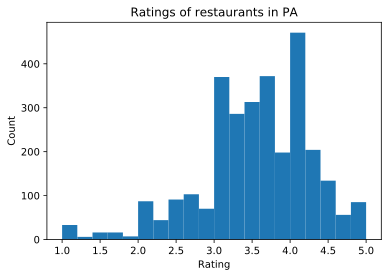

In [41]:
# each restaurant's average rating 
rest_mean = np.array([XX[XX[:,i]!=0,i].mean() for i in range(XX.shape[1])])
plt.hist(rest_mean,bins=20)
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Ratings of restaurants in PA')

Text(0.5,1,"User's ratings")

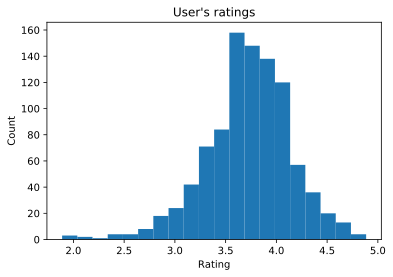

In [42]:
# each user's average ratings
user_mean = np.array([XX[i,XX[i,:]!=0].mean() for i in range(XX.shape[0])])
plt.hist(user_mean,bins=20)
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('User\'s ratings')

In [20]:
# ##### Test ##### 
# nonzero = np.where(XX[:,300]>0)
# x200 = XX[:,300][nonzero]
# print(Counter(x200))
# name = restaurant_name[300] # Pizza Bellino
# print(name)
# business[business['name'] == '"Spice Affair"'] #business id: 49sbCG7F2jvqJsfG6-N8Rw

# stars = np.array(PA_review[PA_review['business_id']=='49sbCG7F2jvqJsfG6-N8Rw']['stars'])
# print(Counter(stars))

In [21]:
#  Export the sparse matrix
# XX_sparse = sp.csc_matrix(XX)
# sp.save_npz('sparse_matrix_all.npz',XX_sparse)

###  Recommender Systems: Matrix Factorization Approach

In [57]:
randidx = np.random.permutation(XX.shape[0])
train = int(len(randidx)*0.8)
XX_train = XX[randidx[:train]]
XX_test = XX[randidx[train:]]

#### Loss Function

\begin{equation}
\ell(h_\theta(i,j), X_{ij}) = (h_\theta(i,j) - X_{ij})^2
\end{equation}
but evaluatd _only_ for those entries where we have actually observed a rating in $X$.  That is, defining $S$ as the set of observed user/item ratings
\begin{equation}
S = \{(i,j) : X_{ij} \neq 0\}
\end{equation}

In [59]:
def error(X, U, V):
    """ Compute the mean error of the observed ratings in X and their estimated values. 
        Args: 
            X (numpy 2D array) : a ratings matrix as specified above
            U (numpy 2D array) : a matrix of features for each user
            V (numpy 2D array) : a matrix of features for each movie
        Returns: 
            (float) : the mean squared error of the observed ratings with their estimated values
        """
# --- Solutions ---
#     return (((U.dot(V.T)-X)[X>0])**2).mean()

    rank_estimated = U.dot(V.T)
    indicator_matrix = X!=0
    err = (rank_estimated[indicator_matrix]-X[indicator_matrix])**2
    err = err.mean()
    return err

#### Alternating Least Square

This algorithm results in the following repeated updates.
\begin{equation}
\begin{split}
u_i & := \left ( \sum_{j : (i,j) \in S} v_j v_j^T \right )^{-1} \left (\sum_{j : (i,j) \in S} v_j X_ij \right ), \;\; \ i=1,\ldots,m \\
v_j & := \left ( \sum_{i : (i,j) \in S} u_i u_i^T \right )^{-1} \left (\sum_{i : (i,j) \in S} u_i X_ij \right ), \;\; j=1,\ldots,n
\end{split}
\end{equation}

In [60]:
def train(X, X_te, k, U, V, niters=50, lam=10, verbose=True):
    """ Train a collaborative filtering model. 
        Args: 
            X (numpy 2D array) : the training ratings matrix as specified above
            X_te (numpy 2D array) : the testing ratings matrix as specified above
            k (int) : the number of features use in the CF model
            U (numpy 2D array) : an initial matrix of features for each user
            V (numpy 2D array) : an initial matrix of features for each movie
            niters (int) : number of iterations to run
            lam (float) : regularization parameter
            verbose (boolean) : verbosity flag for printing useful messages
            
        Returns:
            (U,V) : A pair of the resulting learned matrix factorization
    """
    m, n = X.shape
    D = lam * sp.eye(k)
    W = (X>0).astype(int)
    W_te = (X_te>0).astype(int)
    print("{0:5}|{1:10}|{2:10}".format("Iter","Train Err","Test Err"))
    
    for i in range(niters):
        for j,Wj in enumerate(W.T):
            # fix user, compute item coefficient
            V[j,:] = la.solve(U.T.dot(sp.diags(Wj).dot(U))+D, U.T.dot(X[:,j]))
        for j,Wj in enumerate(W):
            # fix item, compute user coefficient
            U[j,:] = la.solve(V.T.dot(sp.diags(Wj).dot(V))+D, V.T.dot(X[j,:]))
        if verbose and i % 5 == 0:
            print("{0:5d}|{1:10.4f}|{2:10.4f}".format(i,error(X,U,V),error(X_te,U,V)))
    
    return U,V

In [64]:
user_shape = XX_train.shape[0]
item_shape = XX_train.shape[1]
k = 5
# random initialization
U = np.random.rand(user_shape,5)
V = np.random.rand(item_shape,5)
U_,V_ = train(XX_train,XX_test,5,U,V)

Iter |Train Err |Test Err  


/opt/packages/python/Python-3.5.2-icc-mkl/lib/python3.5/site-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 764 but corresponding boolean dimension is 191
  from ipykernel import kernelapp as app


    0|    1.5790|    2.2991
    5|    1.0218|    1.7945
   10|    0.9967|    1.7639
   15|    0.9915|    1.7657
   20|    0.9894|    1.7682
   25|    0.9883|    1.7696
   30|    0.9877|    1.7702
   35|    0.9872|    1.7705
   40|    0.9869|    1.7706
   45|    0.9867|    1.7706


#### Recommendation
For each user, recommend the the movie with the highest predicted rating for that user that the user **hasn't** seen before. 

In [68]:
def recommend(X, U, V, restNames):
    """ Recommend a new movie for every user.
        Args: 
            X (numpy 2D array) : the training ratings matrix as specified above
            U (numpy 2D array) : a learned matrix of features for each user
            V (numpy 2D array) : a learned matrix of features for each movie
            restNames : a list of restaurant names corresponding to the columns of the ratings matrix
        Returns
            (list) : a list of restaurnat names recommended for each user
    """
    recommend = []
    X_pred = U.dot(V.T)
    for user in range(len(X_pred)):
        X_pred_sort = np.argsort(X_pred[user])[::-1]
        rest_notseen = X_pred_sort[X[user]==0]
        recommend.append(restNames[rest_notseen[0]])
    return recommend

In [70]:
recommendations = recommend(XX_train, U_, V_, restaurant_name)
print(recommendations[:20])

["Nicky's Thai Kitchen", "Nicky's Thai Kitchen", "Nicky's Thai Kitchen", 'Steel City Steak House', "Nicky's Thai Kitchen", 'Streets On Carson', "Nicky's Thai Kitchen", "Nicky's Thai Kitchen", "Nicky's Thai Kitchen", "Nicky's Thai Kitchen", "Nicky's Thai Kitchen", 'China Gate', "Nicky's Thai Kitchen", 'Steel City Steak House', 'Streets On Carson', "Nicky's Thai Kitchen", "Nicky's Thai Kitchen", "Nicky's Thai Kitchen", "Veltre's Pizza", "Nicky's Thai Kitchen"]
